In [1]:
# Fix randomness and hide warnings
seed = 42
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
# Import other libraries
import cv2
from tensorflow.keras.applications.xception import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from DataLoader import load_data

In [4]:
data_file = np.load("./public_data.npz", allow_pickle=True)
data = data_file["data"]
y = data_file["labels"]
y[y == "healthy"] = 0
y[y == "unhealthy"] = 1
y = y.astype(np.float32)

Removing trolls, shreks and duplicates


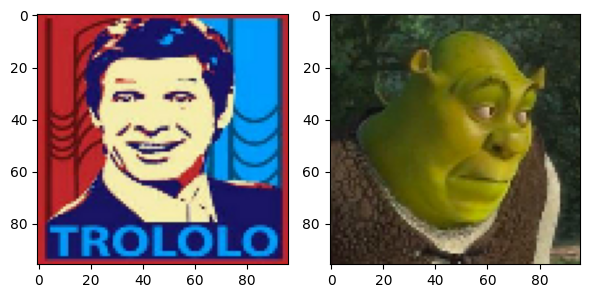

In [5]:
print("Removing trolls, shreks and duplicates")
initialDataN = data.shape[0]


troll = data[338]
shrek = data[58]


fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(troll / 255)
axes[1].imshow(shrek / 255)
plt.tight_layout()
plt.show()

In [6]:
mask = []
for i in range(data.shape[0]):
    if np.array_equal(data[i], troll) or np.array_equal(data[i], shrek):
        mask.append(False)
    else:
        mask.append(True)
data = data[mask]
y = y[mask]

In [7]:
data, indexes = np.unique(data, axis=0, return_index=True)
y = y[indexes]

print("Removed Images: " + str(initialDataN - data.shape[0]))

Removed Images: 350


In [8]:
y = tfk.utils.to_categorical(y, num_classes=2)

In [9]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data, y, random_state=seed, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, random_state=seed, test_size=0.2, stratify=y_train_val)

In [10]:
model = tfk.applications.Xception(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
)

In [11]:
model.trainable = False

data_augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal"),
    tfkl.RandomRotation(0.1),
])

inputs = tfk.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)

scale_layer = tfkl.Rescaling(scale = 1/127.5, offset=-1)
x = scale_layer(x)

x = model(x, training=False)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dropout(0.2)(x)

output = tfkl.Dense(2, activation="softmax")(x)
tl_model = tfk.Model(inputs, output)
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [12]:
# Train the model
tl_history = tl_model.fit(
    x = X_train, # We need to apply the preprocessing
    y = y_train,
    batch_size = 16,
    epochs = 20,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/20
194/194 [==============================] - 15s 54ms/step - loss: 0.5883 - accuracy: 0.6878 - val_loss: 0.5286 - val_accuracy: 0.7345
Epoch 2/20
194/194 [==============================] - 9s 45ms/step - loss: 0.5261 - accuracy: 0.7352 - val_loss: 0.4768 - val_accuracy: 0.7771
Epoch 3/20
194/194 [==============================] - 9s 44ms/step - loss: 0.5154 - accuracy: 0.7548 - val_loss: 0.4921 - val_accuracy: 0.7474
Epoch 4/20
194/194 [==============================] - 8s 44ms/step - loss: 0.5159 - accuracy: 0.7500 - val_loss: 0.5240 - val_accuracy: 0.7526
Epoch 5/20
194/194 [==============================] - 8s 44ms/step - loss: 0.4990 - accuracy: 0.7626 - val_loss: 0.4920 - val_accuracy: 0.7655
Epoch 6/20
194/194 [==============================] - 8s 43ms/step - loss: 0.4902 - accuracy: 0.7803 - val_loss: 0.4668 - val_accuracy: 0.7848
Epoch 7/20
194/194 [==============================] - 8s 44ms/step - loss: 0.4891 - accuracy: 0.7697 - val_loss: 0.4874 - val_accuracy: 0.770

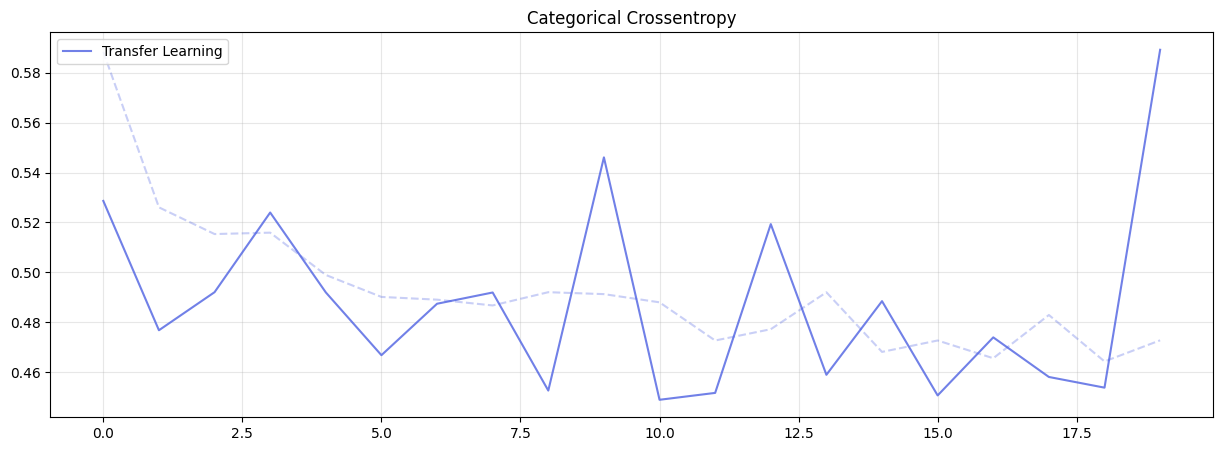

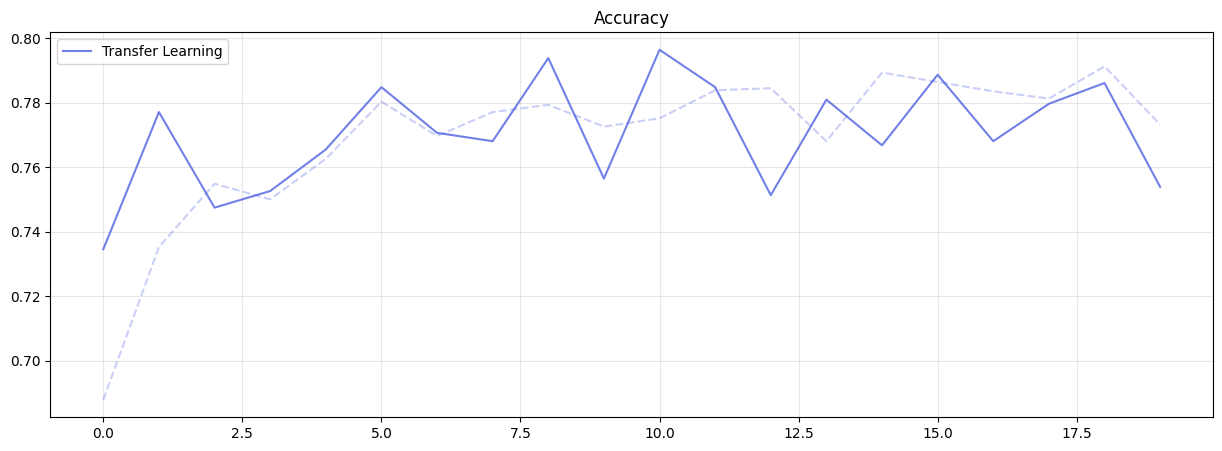

In [13]:
# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [14]:
# Save the best model
tl_model.save('XceptionTransferLearning_AUG')
del tl_model

In [15]:
ft_model = tf.keras.models.load_model('XceptionTransferLearning_AUG')

In [17]:
ft_model.get_layer('xception').trainable = True

In [19]:
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics=['accuracy'])


In [20]:
ft_history = ft_model.fit(
    x = X_train, # We need to apply the preprocessing
    y = y_train,
    batch_size = 16,
    epochs = 10,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/10
194/194 [==============================] - 46s 129ms/step - loss: 0.4471 - accuracy: 0.7993 - val_loss: 0.4192 - val_accuracy: 0.8170
Epoch 2/10
194/194 [==============================] - 24s 123ms/step - loss: 0.4024 - accuracy: 0.8180 - val_loss: 0.4114 - val_accuracy: 0.8183
Epoch 3/10
194/194 [==============================] - 24s 123ms/step - loss: 0.3526 - accuracy: 0.8402 - val_loss: 0.4028 - val_accuracy: 0.8247
Epoch 4/10
194/194 [==============================] - 24s 123ms/step - loss: 0.3272 - accuracy: 0.8605 - val_loss: 0.4287 - val_accuracy: 0.8286
Epoch 5/10
194/194 [==============================] - 24s 122ms/step - loss: 0.2943 - accuracy: 0.8653 - val_loss: 0.3801 - val_accuracy: 0.8273
Epoch 6/10
194/194 [==============================] - 24s 123ms/step - loss: 0.2916 - accuracy: 0.8773 - val_loss: 0.3750 - val_accuracy: 0.8531
Epoch 7/10
194/194 [==============================] - 24s 123ms/step - loss: 0.2541 - accuracy: 0.8892 - val_loss: 0.3839 - val_ac

In [22]:
# Save the best model
ft_model.save('XceptionFineTuning_AUG')
del ft_model

AttributeError: 'dict' object has no attribute 'save'

: 